<a href="https://colab.research.google.com/github/restrepo/Covid-19/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 data

Use of [public Covid-19 in GitHub](https://github.com/CSSEGISandData/COVID-19) data from: 
[Center for Systems Science and Engineering (CSSE)](https://systems.jhu.edu/):

* Hongru Du, Lauren Gardner, and Ensheng Dong, An interactive web-based dashboard to track COVID-19 in real time, http://www.thelancet.com/infection Published:February 19, 2020, DOI:https://doi.org/10.1016/S1473-3099(20)30120-1

As an example of use of the data, we want to reproduce the results of:
* [Así evoluciona la curva del Coronavirus en España y en cada CCAA](https://elpais.com/sociedad/2020/03/13/actualidad/1584091954_865510.html)

<img src='https://github.com/restrepo/Covid-19/blob/master/elpais.png?raw=1' height="80" >

and to make similar plots for other countries


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import pandas as pd
import re
#See https://strftime.org/
import datetime

## Load data

In [0]:
cva=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
cva=cva.reset_index(drop=True)

## Normalize data
Be sure to have only a row for country

In [4]:
def get_sum_series(cvn):
    cs=cvn.sum()
    cs['Province/State']='All'
    cs['Country/Region']=cvn['Country/Region'].unique()[0]
    cs['Lat']=round( cvn['Lat'].mean(),3 )
    cs['Long']=round( cvn['Long'].mean(),3 )
    return cs

cvo=pd.DataFrame()

multi_country=[]
for c in cva['Country/Region']:
    if c not in multi_country:
        cvn=cva[cva['Country/Region']==c].reset_index(drop=True)
        if cvn.shape[0]>1:
            multi_country.append(c)
            cvo=cvo.append(get_sum_series(cvn),ignore_index=True)
        else:
            cvo=cvo.append(cvn,sort=False)

cvo=cvo[cva.columns].reset_index(drop=True)

cv=cvo.copy()

cv.shape

(159, 60)

Special cases

In [0]:
sc=cva[cva['Province/State']=='Hong Kong'].reset_index(drop=True)
sc['Country/Region']='Hong Kong'
if sc.shape[0]==1:
    cv=cv.append(sc,sort=False)
    cv=cv.reset_index(drop=True)

## Make a list from infections rows

In [6]:
d=[ c for c in cv.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]

#https://www.tutorialspoint.com/How-to-sort-a-Python-date-string-list
#updeted date
cv['tolist']=cv[d].values.tolist()

d.sort(key=lambda date: datetime.datetime.strptime(date, "%m/%d/%y"))

cv[:1]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,tolist
0,NaN,Thailand,15.0,101.0,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177.0,"[2.0, 3.0, 5.0, 7.0, 8.0, 8.0, 14.0, 14.0, 14...."


In [7]:
dmax=d[-1]
dmax

'3/17/20'

## Reproduce "El País" plot
Set of minimal number of infections to catch up the exponential growth: `mininf=50`

Text(0, 0.5, 'infections')

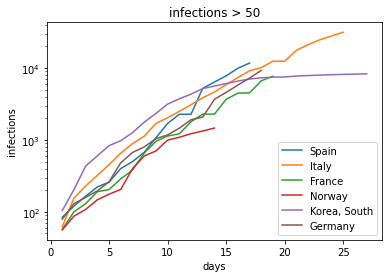

In [8]:
cntr=['Spain','Italy','France','Norway','Korea, South','Germany']

mininf=50
for c in cntr:
    idxs=cv[ cv['Country/Region']== c ].index
    if len(idxs)==1:
        idx=idxs[0]
    else:
        print('Several Province/State')
        
    y=[l for l in cv.loc[idx,'tolist'] if l>mininf]
    ylen=len(y)
    x=range( 1,ylen+1 )
    #plt.semilogy(x,y,label='{}'.format(c))
    plt.plot(x,y,label='{}'.format(c))
    
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.title('infections > {}'.format(mininf))
plt.xlabel('days')
plt.ylabel('infections')
#plt.xlim(1,10)
#plt.ylim(1,200)
#plt.savefig('elpais_recover_2020_03_16.png')

## Make similar plots for all the countries

Country Lat
--------------------
Japan 36.0
Singapore 1.2833
Bahrain 26.0275
Kuwait 29.5
Hong Kong 22.3
--------------------


(40, 30000)

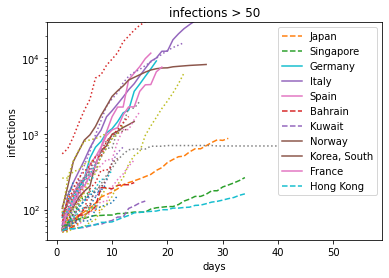

In [9]:
print('Country','Lat')
print('-'*20)
cntr=cv['Country/Region'].values
low_countries=[]
mininf=50
days_after=13
maxinf=300
for c in cntr:
    idxs=cv[ cv['Country/Region']== c ].index
    #Avoid multi_contry entries
    if len(idxs)==1:
        idx=idxs[0]
    else:
        pass
        #print('Several Province/State')
        
    y=[l for l in cv.loc[idx,'tolist'] if l>mininf]
    ylen=len(y)
    x=range( 1,ylen+1 )
    if len(x)>days_after and y[days_after]<maxinf:
        low_countries.append(c)
        print(c,cv.loc[idx,'Lat'])
    if c in ['Spain','Italy','France','Norway','Korea, South','Germany']:
        plt.plot(x,y,label='{}'.format(c))
    elif c in low_countries:
        plt.plot(x,y,'--',label='{}'.format(c))
    else:
        plt.plot(x,y,':')

print('-'*20)
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.title('infections > {}'.format(mininf))
plt.xlabel('days')
plt.ylabel('infections')
#plt.xlim(10,20)
plt.ylim(mininf-10,30000)

## Slow-exponential-growth countries

Country Lat
--------------------
Thailand 15.0
Japan 36.0
Singapore 1.2833
Malaysia 2.5
Australia -24.503
Taiwan* 23.7
Vietnam 16.0
Hong Kong 22.3
--------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


(7.0472961969452035, 7000)

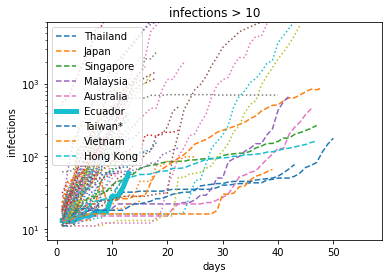

In [10]:
print('Country','Lat')
print('-'*20)
cntr=cv['Country/Region'].values
low_countries=[]
mininf=10
days_after=35
maxinf=400
for c in cntr:
    idxs=cv[ cv['Country/Region']== c ].index
    #Avoid multi_contry entries
    if len(idxs)==1:
        idx=idxs[0]
    else:
        pass
        #print('Several Province/State')
        
    y=[l for l in cv.loc[idx,'tolist'] if l>mininf]
    ylen=len(y)
    x=range( 1,ylen+1 )
    if len(x)>days_after and y[days_after]<maxinf:
        low_countries.append(c)
        print(c,cv.loc[idx,'Lat'])
    if c in ['Ecuador']:
        plt.plot(x,y,label='{}'.format(c),lw=5)
    elif c in low_countries:
        plt.plot(x,y,'--',label='{}'.format(c))
    else:
        plt.plot(x,y,':')

print('-'*20)
plt.legend(loc='upper left')
plt.xscale('linear')
plt.yscale('log')
plt.title('infections > {}'.format(mininf))
plt.xlabel('days')
plt.ylabel('infections')
#plt.xlim(10,20)
plt.ylim(mininf-10,7000)

To check the reason why some contries may no exhibit an strong exponential growth, see [References](./covid.ipynb#References) at the end


## Latin America

Text(0, 0.5, 'infections')

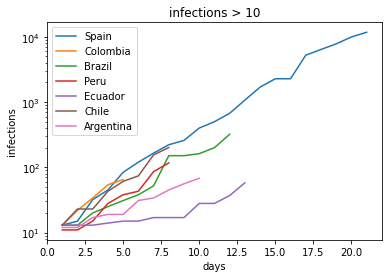

In [11]:
cntr=['Spain','Colombia','Brazil','Peru','Ecuador', 'Chile','Argentina']

mininf=10
for c in cntr:
    idxs=cv[ cv['Country/Region']== c ].index
    if len(idxs)==1:
        idx=idxs[0]
    else:
        print('Several Province/State')
        
    y=[l for l in cv.loc[idx,'tolist'] if l>mininf]
    ylen=len(y)
    x=range( 1,ylen+1 )
    #plt.semilogy(x,y,label='{}'.format(c))
    plt.plot(x,y,label='{}'.format(c))
    
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.title('infections > {}'.format(mininf))
plt.xlabel('days')
plt.ylabel('infections')
#plt.xlim(1,12)
#plt.ylim(1,200)
#plt.savefig('elpais_recover_2020_03_16.png')

## Fit to exponential model
See: 
* https://twitter.com/burkert_andreas/status/1239692655833071616
    * https://raw.githubusercontent.com/restrepo/Covid-19/master/covid-19.jpeg

* Method for Python explained in 
[Covid-19 infection in Italy. Mathematical models and predictions](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d):

> While the logistic model describes an infection growth that is going to stop in the future, the exponential model describes an unstoppable infection growth. For example, if a patient infects 2 patients per day, after 1 day we’ll have 2 infections, 4 after 2 days, 8 after 3 and so on. The most generic exponential function is:

$$f(x,a,b,c)=a\operatorname{e}^{b(x-c)}\,.$$

In [0]:
from scipy.optimize import curve_fit
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

Select a range of dates

In [0]:
def date_range(date_start='2/23/20',date_end='3/03/20',date_step=1):
    dr=[]
    start = datetime.datetime.strptime(date_start, "%m/%d/%y")
    end = datetime.datetime.strptime(date_end, "%m/%d/%y")
    step = datetime.timedelta(days=date_step)
    while start <= end:
        #avoid leading zeroes: https://stackoverflow.com/a/2073189/2268280
        dr.append(start.strftime("%-m/%-d/%y"))
        start += step
    return dr

In [14]:
c='Italy'
dr=date_range('2/23/20',date_end='3/03/20')
cvrg=cv[cv['Country/Region']==c].reset_index(drop=True)
y=cvrg[dr].values.tolist()[0]
x=range(1,len(y)+1)
exp_fit = curve_fit(exponential_model,x,y,p0=[1,1,1])

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0, 0.5, 'infections')

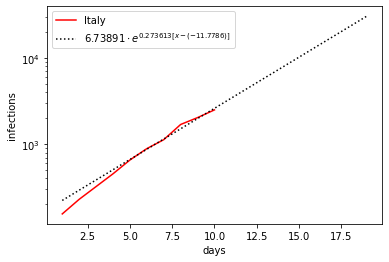

In [15]:
xx=range(x[0],x[-1]+10)
plt.plot(x,y,'r-',label=c)
plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]),
         'k:',
         label=r'$%g\cdot e^{%g[x-(%g)]}$' %(exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) )
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('days')
plt.ylabel('infections')

### Exponential model for Colombia

In [0]:
c='Colombia'
max_forecast=1000
prediction=16
extra_days=15
start_day='3/9/20'
dr=date_range(start_day,date_end=dmax)
cvrg=cv[cv['Country/Region']==c].reset_index(drop=True)
y=cvrg[dr].values.tolist()[0]
x=range(1,len(y)+1)
exp_fit = curve_fit(exponential_model,x,y,p0=[1,0.4,3])

In [31]:
exp_fit[0]

array([10.03834353,  0.3705014 ,  3.80385135])

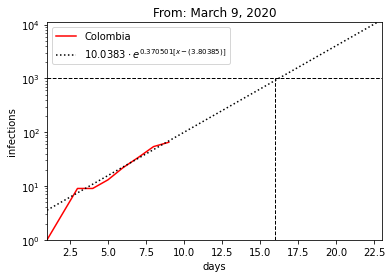

In [32]:
xx=range(x[0],x[-1]+extra_days)
if min(y)>0:
    ymin=min(y)
else:
    ymin=1

plt.plot(x,y,'r-',label=c)
plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]),
         'k:',
         label=r'$%g\cdot e^{%g[x-(%g)]}$' %(exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) )

plt.hlines(max_forecast,xx[0],xx[-1],linestyles='--',lw=1)
plt.vlines(prediction,ymin,max_forecast,linestyles='--',lw=1)

plt.title('From: {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y") ) )
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('days')
plt.ylabel('infections')
plt.xlim(xx[0],xx[-1])
plt.ylim(ymin,max_forecast+10000)
plt.savefig('Colombia.png')

Prediction next day

In [33]:
exp_fit_co=exp_fit[0].copy()
exponential_model_co=lambda x: exponential_model(x, exp_fit_co[0],exp_fit_co[1],exp_fit_co[2]  )
print('day {}:  {} infections'.format(x[-1]+1,exponential_model_co(x[-1]+1  ).round(1)) )

day 10:  99.7 infections


Other country

(27, 11000)

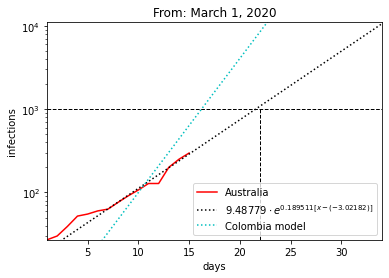

In [34]:
c='Australia'
max_forecast=1000
prediction=22
start_day='3/1/20'
dr=date_range(start_day,date_end='3/15/20')
cvrg=cv[cv['Country/Region']==c].reset_index(drop=True)
y=cvrg[dr].values.tolist()[0]
x=range(1,len(y)+1)
exp_fit = curve_fit(exponential_model,x,y,p0=[1,0.4,3])

xx=range(x[0],x[-1]+20)
if min(y)>0:
    ymin=min(y)
else:
    ymin=1

plt.plot(x,y,'r-',label=c)
plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]),
         'k:',
         label=r'$%g\cdot e^{%g[x-(%g)]}$' %(exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) )

plt.plot(xx,exponential_model_co(xx),'c:',label='Colombia model')

plt.hlines(max_forecast,xx[0],xx[-1],linestyles='--',lw=1)
plt.vlines(prediction,ymin,max_forecast,linestyles='--',lw=1)

plt.title('From: {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y") ) )
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('days')
plt.ylabel('infections')
plt.xlim(xx[0],xx[-1])
plt.ylim(ymin,max_forecast+10000)

## References
About meteorological conditions for Covid-19

* Sajadi, Mohammad M. and Habibzadeh, Parham and Vintzileos, Augustin and Shokouhi, Shervin and Miralles-Wilhelm, Fernando and Amoroso, Anthony, Temperature and Latitude Analysis to Predict Potential Spread and Seasonality for COVID-19 (March 5, 2020). Available at SSRN: https://ssrn.com/abstract=3550308 or http://dx.doi.org/10.2139/ssrn.3550308
    * [El coronavirus en tierra caliente: ¿igual, peor o menos grave?](https://www.elespectador.com/coronavirus/el-coronavirus-en-tierra-caliente-igual-peor-o-menos-grave-articulo-909335)

* Wang, Jingyuan and Tang, Ke and Feng, Kai and Lv, Weifeng, High Temperature and High Humidity Reduce the Transmission of COVID-19 (March 9, 2020). Available at SSRN: https://ssrn.com/abstract=3551767 or http://dx.doi.org/10.2139/ssrn.3551767 
> $R = 3.968 - 0.0383\cdot \text{Temperature} - 0.0224\cdot \text{Relative Humidity}$
    * [Twitter thread](https://twitter.com/zuluagajorge/status/1239925580038049793)
* [Singapore contained Coronavirus. Could other countries learn from its approach?](https://www.weforum.org/agenda/2020/03/singapore-response-contained-coronavirus-covid19-outbreak/)
* [Will spring slow spread of coronavirus in northern hemisphere?](https://www.theguardian.com/world/2020/mar/11/will-spring-slow-spread-of-coronavirus-in-northern-hemisphere)
* [Coronavirus: Why You Must Act Now](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca)
* [Es muy probable que el SARS-COV-2 se atenúe y vuelva cada invierno, como la gripe](https://www.elespectador.com/coronavirus/es-muy-probable-que-el-sars-cov-2-se-atenue-y-vuelva-cada-invierno-como-la-gripe-articulo-909696)
> Las altas temperaturas son excelentes porque los coronavirus son muy sensibles al calor: cada día que pasan a 37 grados, pierden 10 veces su infectividad. Por tanto, en tres días calentitos se bajaría mil veces su capacidad de infección.
* Jin Bu, Dong-Dong Peng, Hui Xiao, Qian Yue, Yan Han, Yu Lin, Gang Hu, Jing Chen, Analysis of meteorological conditions and prediction of epidemic trend of 2019-nCoV infection in 2020, medRxiv 2020.02.13.20022715; doi: https://doi.org/10.1101/2020.02.13.20022715
> From a global perspective, cities with a mean temperature below 24 degree Celsius are all high-risk cities for 2019-nCoV transmission before June.

In [0]:
R=lambda T,H: 3.968 - 0.0383*T - 0.022*H

Global results in Fig. 4 (a) March (b) July in http://dx.doi.org/10.2139/ssrn.3551767

In [36]:
# Japan - July from paper
R(28,85)

1.0256

In [37]:
# Medellín - March from https://en.wikipedia.org/wiki/Medell%C3%ADn#Climate
R(23,65)

1.6571

In [38]:
# Bogotá - March from https://en.wikipedia.org/wiki/Bogot%C3%A1#Climate
R(15,75)

1.7435

In [39]:
cv[cv['Country/Region']=='Colombia'][[dmax]]

,3/17/20
73,65.0
